In [3]:
import numpy as np
import random
from itertools import product                   

In [110]:
def binomial(x):
    if isinstance(x, (list, tuple)):
        x = np.array(x, dtype=np.float32)
    return np.stack(
        [
            x[0]**2,
            x[0],
            x[0]*x[1],
            x[1],
            x[1]**2,
            np.ones(shape=x[0].shape)
        ], 0)

def new_layer(conn, layers, weights):
    if conn:
        new_node = max(list(conn.keys()))+1
    else:
        new_node = max(layers[-1])+1
    if len(layers)>1:
        pool = layers[-1]+layers[0]
    else:
        pool = layers[0]
    new_layer = {n+new_node:x for n,x in enumerate(product(pool, repeat=2))}
    
    layers.append(list(new_layer.keys()))
    
    for n in layers[-1]:
        weights[n] = np.array([random.random() for _ in range(6)], dtype=np.float32)
    
    conn.update(new_layer)

def calculate(conn, layers, weights, values):
    """
    inputs: {input: [value list]} dict
    """
    values = {k: np.array(v, dtype=np.float32) for k, v in values.items()}
    for nl, layer in enumerate(layers[1:]):
        for nn, node in enumerate(layer):
            left, right = conn[node]
            values[node] = np.einsum("ij,i->j",binomial([values[left], values[right]]),weights[node])
    return values


def regress(conn, layers, weights, inputs, true_values, keep=3, conv_thres=1, iter_thres=1000):
    error_keep_best = np.zeros((keep))
    error_prev = np.ones((keep), dtype=np.float32)*conv_thres
    iteration = 0
    if isinstance(true_values, (list, tuple)):
        true_values = np.array(true_values, dtype=np.float32)
    n_points = true_values.shape[0]
    while (np.abs(error_keep_best - error_prev) >= conv_thres).all() and iteration < iter_thres:
        values = calculate(conn, layers, weights, inputs)
        out_layer_values = np.array([values[n] for n in layers[-1]], dtype=np.float32)
        iteration += 1
        error_prev = error_keep_best
        error = out_layer_values - np.einsum("ij,j->ij", np.ones_like(out_layer_values), true_values)
        speed = 1/2+(iter_thres-iteration)/(2*iter_thres)
        for nn, node in enumerate(layers[-1]):
            left, right = conn[node]
            dw = np.einsum("ij,j->i",binomial([values[left], values[right]]), error[nn])
            weights[node] -= dw/np.linalg.norm(dw)*speed
        
        best_nodes, error_keep_best = list(zip(*sorted(zip(layers[-1], error), key=lambda x: np.sum(x[1]**2))[:keep]))
        error_keep_best = np.sum(np.array(error_keep_best)**2, 1)
    return best_nodes, error_keep_best

def prune(conn, layers, weights, root):
    new_layers = [[] for _ in layers]
    new_layers[-1].append(root)
    new_connections = {root: conn[root]}
    new_weights = {root: weights[root]}
    
    child = list(new_connections[root])
    
    for nl in range(len(layers)-2, -1, -1):
        for node in layers[nl]:
            if node in child:
                new_layers[nl].append(node)
                if node in conn:
                    new_connections[node] = conn[node]
                    new_weights[node] = weights[node]
                child.remove(node)
        for node in new_layers[nl]:
            if node in conn:
                child += list(conn[node])
        child = list(set(child))
    
    return new_connections, new_layers, new_weights

def grow(inputs, 
         true_values,
         iter_thres = 10,
         goal = 1,
         keep = 3,
         return_everything = False):
    """
    inputs: {input: [value list]} dict
    """
    model_inputs = tuple(inputs.keys())
    layers = [model_inputs]
    weights = {}
    connections = {}
    errors = np.array([goal])
    iteration = 0
    
    pconnections, players, pweights, perrors = connections.copy(), layers.copy(), weights.copy(), errors.copy()
    
    while (np.abs(errors) >= goal).all() and iteration < iter_thres:
        if np.sum(errors-perrors)>0 and iteration > 1:
            connections, layers, weights, errors = pconnections, players, pweights, perrors
            break
    
        pconnections, players, pweights, perrors = connections.copy(), layers.copy(), weights.copy(), errors.copy()
        iteration += 1
        
        new_layer(connections, layers, weights)

        layers[-1], errors = regress(connections, layers, weights, inputs, true_values, keep)
    if not return_everything:
        root = layers[-1][0]
        best_tree = prune(connections, layers, weights, root)
        return best_tree, root, errors[0]
    else:
        return connections, layers, weights, errors

0.49125612


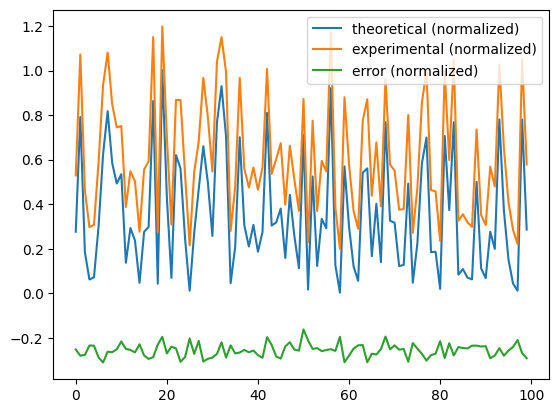

In [133]:
n_p = 100
inps = (0,1)

t_f = lambda x: x[1]**3+x[0]**2*0.5
t_p = {i: [random.random() for _ in range(n_p)] for i in inps}
t_y = list(map(t_f,zip(*t_p.values())))


bino = lambda x,w: np.einsum("i->", w*binomial(x))
ass = np.array([1,1,1,1,1,1], dtype=np.float32)
tree, root, error = grow(t_p, t_y, goal=0.01)

x = list(range(n_p))
c_p = {i: [random.random() for _ in range(n_p)] for i in inps}
c_y = np.array(list(map(t_f,zip(*c_p.values()))))

theor_norm = c_y/(np.max(c_y)-np.min(c_y))
experimental = calculate(*tree, c_p)[root]
exp_norm = experimental/(np.max(experimental)-np.min(experimental))
print(error)

fig, ax = plt.subplots()
th, = ax.plot(x, theor_norm, label="theoretical (normalized)")
ex, = ax.plot(x, exp_norm, label="experimental (normalized)")
er, = ax.plot(x, theor_norm-exp_norm, label="error (normalized)")
ax.legend(handles=[th,ex,er])

In [ ]:

def div_mx(conn, layers, weights, values, n_points):
    dn_dl = lambda w: lambda x, y: 2*w[0]*x+w[1]+w[2]*y
    dn_dr = lambda w: lambda x, y: 2*w[4]*y+w[3]+w[2]*x
    
    d = np.zeros((max(list(conn.keys()))+1,2,n_points))
    for layer in (layers[1:])[::-1]:
        for node in layer:
            left, right = conn[node]
            d[node][0] = np.array(list(map(dn_dl(weights[node]), values[left], values[right])), dtype=np.float32)
            d[node][1] = np.array(list(map(dn_dr(weights[node]), values[left], values[right])), dtype=np.float32)
    
    return d

def dn_dw(conn, layers, weights, node, values, n_points):
    dm = div_mx(conn, layers, weights, values, n_points)
    
    def dn_dn(node):
        d = np.ones(n_points)

        for layer in layers[1:]:
            for pnode in layer:
                if node in conn[pnode]:
                    pleft, pright = conn[pnode]
                    if node == pleft:
                        d *= dm[pnode][0]
                    if node == pright:
                        d *= dm[pnode][1]
                    d *= dn_dn(pnode)
        return d
    
    left, right = conn[node]
    dw = binomial((values[left], values[right]))
    return np.einsum("ij,j->i", dw, dn_dn(node))

def net_div(conn, layers, weights, values, root_error, n_points):
    nd = np.array([np.array([np.zeros(6) for n in l], dtype=np.float32) for l in layers], dtype=object)
    for nl, layer in enumerate(layers[1:]):
        for nn, node in enumerate(layer):
            nd[nl+1][nn] = dn_dw(conn, layers, weights, node, values, n_points)*root_error
    return nd

def regress_whole_net(conn, layers, weights, inputs, true_values, keep=3, conv_thres=1, iter_thres=1000):
    root_error_keep_best = np.zeros((keep))
    root_error_prev = np.ones((keep), dtype=np.float32)*conv_thres
    iteration = 0
    if isinstance(true_values, (list, tuple)):
        true_values = np.array(true_values, dtype=np.float32)
    n_points = true_values.shape[0]
    while (np.abs(root_error_keep_best - root_error_prev) >= conv_thres).all() and iteration < iter_thres:
        values = calculate(conn, layers, weights, inputs)
        out_layer_values = np.array([values[n] for n in layers[-1]], dtype=np.float32)
        iteration += 1
        root_error_prev = root_error_keep_best
        root_error = np.einsum("ij->i", out_layer_values - np.einsum("ij,j->ij", np.ones_like(out_layer_values), true_values))
        
        best_nodes, root_error_keep_best = list(zip(*sorted(zip(layers[-1], root_error), key=lambda x: x[1])[:keep]))
        root_error_keep_best = np.array(root_error_keep_best)
        root_error_norm = np.linalg.norm(root_error_keep_best)
        print(root_error_norm)

        dw = [net_div(conn, layers, weights, values, err/root_error_norm, n_points) for err in root_error_keep_best]
        dw = np.sum(dw,0)
        descent_rate=(iter_thres-iteration)/iter_thres
        for dln, dw_layer in enumerate(dw[1:]):
            for dnn, dw_node in enumerate(dw_layer):
                node = layers[dln+1][dnn]
                weights[node] -= dw_node/np.linalg.norm(dw_node)*descent_rate
                
    return best_nodes, root_error_keep_best